# ChEMBL Compound Data Acquisition
## Extracting Bioactivity Data for a Target

### **Project Overview**
This project retrieves and processes bioactivity and compound data from the ChEMBL database for the target protein **Epidermal Growth Factor Receptor (EGFR kinase)**.  
The final dataset includes molecular properties, bioactivity values (IC50), and pIC50 scores, which are essential for cheminformatics analysis and drug discovery.

### **Key Steps**
1. Connect to ChEMBL
2. Retrieve Target Data
3. Fetch Bioactivity Data
4. Preprocess Bioactivity Data
5. Retrieve Compound Data
6. Preprocess Compound Data
7. Merge Bioactivity & Compound Data
8. Calculate pIC50
9. Visualize Top Compounds
10. Freeze Data to ChEMBL 27

### **Requirements**
- Python 3.x
- Libraries: `pandas`, `numpy`, `rdkit`, `chembl_webresource_client`, `tqdm`

#### Citation : https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x

import os

In [ ]:
os.chdir("F:/CHEMOINFORMATICS")

#### Importing Required Libraries

- **Math & File Handling**: `math`, `Path`, `ZipFile`, `TemporaryDirectory`
- **Data Processing**: `numpy`, `pandas`
- **Cheminformatics**: `rdkit (PandasTools)`
- **ChEMBL API**: `chembl_webresource_client`
- **Progress Tracking**: `tqdm`

These libraries help with **data retrieval, processing, and visualization**.

In [110]:
pip install --upgrade rdkit pandas

   ---------------------------------------- 0.0/22.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/22.5 MB ? eta -:--:--
    --------------------------------------- 0.5/22.5 MB 1.4 MB/s eta 0:00:16
   - -------------------------------------- 0.8/22.5 MB 1.5 MB/s eta 0:00:15
   - -------------------------------------- 1.0/22.5 MB 1.6 MB/s eta 0:00:14
   -- ------------------------------------- 1.6/22.5 MB 1.7 MB/s eta 0:00:13
   --- ------------------------------------ 2.1/22.5 MB 1.8 MB/s eta 0:00:12
   ---- ----------------------------------- 2.6/22.5 MB 1.9 MB/s eta 0:00:11
   ----- ---------------------------------- 3.1/22.5 MB 2.0 MB/s eta 0:00:10
   ------ --------------------------------- 3.7/22.5 MB 2.1 MB/s eta 0:00:10
   ------- -------------------------------- 4.2/22.5 MB 2.2 MB/s eta 0:00:09
   -------- ------------------------------- 5.0/22.5 MB 2.3 MB/s eta 0:00:08
   ---------- ----------------------------- 5.8/22.5 MB 2.4 MB/s eta 0:00:07
   ----------

  You can safely remove it manually.
  You can safely remove it manually.


In [3]:
!pip install tqdm

In [4]:
!pip install chembl_webresource_client

In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

##### **1 Connect to ChEMBL**
- Establish connection using the ChEMBL API.

In [20]:
# Define the project root directory
HERE = Path("F:/CHEMOINFORMATICS")

# Define the data directory
DATA = HERE / "data"

In [21]:
targets_api = new_client.target  # Access target data ("EGFR kinase" and retrieve ChEMBL ID).
compounds_api = new_client.molecule  # Access compound data (retrieve SMILES, molecular properties).
bioactivities_api = new_client.activity  # Access bioactivity data (filter IC50 values for a target).

In [22]:
type(targets_api) # To check type of object

chembl_webresource_client.query_set.QuerySet

##### **2 Retrieve Target Data**

1. **Search for Protein Target (EGFR kinase)**  
   Use the ChEMBL API to search for the target protein **EGFR kinase**.

2. **Extract ChEMBL Target ID**  
   Retrieve the **ChEMBL Target ID** for EGFR kinase from the search results.

3. **Get UniProt ID**  
   - https://www.uniprot.org/ and search for **EGFR kinase**.
   - Retrieve the UniProt ID: **P00533**.

4. **Use UniProt ID to Get Target Information**  
   Use the UniProt ID (`P00533`) to fetch additional target information from ChEMBL or UniProt.

---

In [23]:
uniprot_id = "P00533"

In [24]:
# To get the target information from ChEMBL with specific values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [25]:
# Convert ChEMBL target data to DataFrame and display it.
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION
9,Homo sapiens,CCN2-EGFR,CHEMBL5465557,PROTEIN-PROTEIN INTERACTION


In [26]:
# Select target (target ChEMBL ID)
# Select the first entry as our target of interest: CHEMBL203: Because It is a single protein and represents 
# the human Epidermal growth factor receptor (EGFR, also named erbB1)

target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

In [27]:
#Save selected ChEMBL ID to a variable
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL203


##### **3. Fetch Bioactivity Data**

* Query bioactivity data for the target.
* Filter for: Human proteins, IC50 bioactivity type, Exact measurements (relation '=') and the Binding assays (assay type 'B')

In [28]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id,  # Filter by target CHEMBL203 for EGFR kinase
    type="IC50",                 # Filter for bioactivity type: IC50
    relation="=",                # Filter for exact measurements (standard relation '=')
    assay_type="B"               # Filter for binding assays (assay type 'B')
).only(
    "activity_id",               # Include activity ID
    "assay_chembl_id",           # Include assay ChEMBL ID
    "assay_description",         # Include assay description
    "assay_type",                # Include assay type
    "molecule_chembl_id",        # Include compound ChEMBL ID
    "type",                      # Include bioactivity type (e.g., IC50)
    "standard_units",            # Include units of measurement (e.g., nM)
    "relation",                  # Include relation (e.g., '=')
    "standard_value",            # Include bioactivity value (e.g., IC50 value)
    "target_chembl_id",          # Include target ChEMBL ID
    "target_organism"            # Include target organism (e.g., Homo sapiens)
)

In [29]:
#Checks the overall structure of bioactivities:

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 11634, <class 'chembl_webresource_client.query_set.QuerySet'>


In [30]:
#Inspects the first record (bioactivities[0]) to understand its structure

print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

In [33]:
#Converts the bioactivities object into a Pandas DataFrame.
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (11634, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50,uM,3000.0


##### **4. Preprocess Bioactivity Data**
- **Clean and Filter Bioactivity Values**:
  - Remove missing values.
  - Standardize units (use `standard_units` and `standard_value` columns).
  - Filter for `nM` units.
- **Remove Duplicates**:
  - Drop duplicate entries (e.g., rows describing the same bioactivity).
- **Drop Non-Standardized Columns**:
  - Remove `units` and `value` columns to avoid confusion.
- **Ensure Numeric Values**:
  - Convert `standard_value` to numeric and drop invalid entries.
- **Rename Columns**:
  - Rename `standard_value` to `IC50` and `standard_units` to `units` for clarity.
- **Reset Index**:
  - Reset the DataFrame index after filtering.

In [34]:
# Check the unique values in the units column of your DataFrame
bioactivities_df["units"].unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol', '10^-8M'], dtype=object)

In [ ]:
# Drop non-standardized columns ('units' and 'value') to use only standardized data.
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)

In [39]:
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [40]:
print(bioactivities_df.columns)  # List all column names

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'type'],
      dtype='object')


In [41]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [42]:
# Convert 'standard_value' column to float for numeric calculations.
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [43]:
# Remove rows with any missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (11633, 11)


In [44]:
# Filter the dataset to keep only entries with 'standard_units' in nM.
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' '/uM']
Number of non-nM entries:    69


In [45]:
# Retain only rows where 'standard_units' is 'nM' for consistency.
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [46]:
bioactivities_df.shape

(11564, 11)

In [47]:
# Remove duplicate entries based on 'molecule_chembl_id', keeping the first occurrence.
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (7334, 11)


In [48]:
# Reset the DataFrame index after removing duplicates
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [49]:
# Rename columns for clarity: 'standard_value' to 'IC50' and 'standard_units' to 'units'.
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [50]:
bioactivities_df.shape

(7334, 11)

##### **5. Retrieve Compound Data**
- **Fetch Compound Structures**:
  - Use `molecule_chembl_id` to retrieve molecular structures from ChEMBL.

In [51]:
# Fetch compound data (ChEMBL IDs and structures) for molecules in the bioactivity dataset.
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [52]:
# Convert the QuerySet to a list with a progress bar for tracking.
compounds = list(tqdm(compounds_provider))

  0%|          | 0/7334 [00:00<?, ?it/s]

In [53]:
# Convert the list of compounds into a DataFrame and check its shape.
compounds_df = pd.DataFrame.from_records(compounds)
compounds_df.shape

(7334, 2)

In [54]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


#### 6. Preprocess and Filter Compound Data

* **Standardize Compound Structures:** Ensure consistent chemical representations.
* **Remove Missing Data:** Eliminate entries with incomplete information.
* **Deduplicate Molecules:** Remove redundant entries based on `molecule_chembl_id`.
* **Generate Canonical SMILES:** Obtain simplified, unique representations of molecules.

In [55]:
#Remove entries with missing molecule structure entry
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.shape

(7327, 2)

In [56]:
#Delete duplicate molecules
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
compounds_df.shape

(7327, 2)

In [57]:
# Extract canonical SMILES from molecule structures

# Inspect the structure of molecule_structures (optional)
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [58]:
canonical_smiles = []  # Initialize list to store SMILES

# Iterate through rows and extract canonical SMILES
for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)  # Handle missing SMILES

compounds_df["smiles"] = canonical_smiles  # Add SMILES column
compounds_df.drop("molecule_structures", axis=1, inplace=True)  # Remove original structure column

print(f"DataFrame shape: {compounds_df.shape}") #print new dataframe shape.

DataFrame shape: (7327, 2)


In [59]:
#Remove all molecules without a canonical SMILES string if prese
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (7327, 2)


In [60]:
# Summary of bioactivity data output
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 7334


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [61]:
# Summary of Compound data output
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 7327


Index(['molecule_chembl_id', 'smiles'], dtype='object')

##### **7. Merge Bioactivity & Compound Data**

* **Combine DataFrames:** Merge `bioactivities_df` and `compounds_df` based on `molecule_chembl_id`.
* **Select Key Columns:** Retain `molecule_chembl_id`, `smiles`, `units`, and `IC50`.

In [62]:
# Merge bioactivity and compound data on 'molecule_chembl_id'.
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

In [63]:
# Reset row indices after merging and print the resulting dataset size.
output_df.reset_index(drop=True, inplace=True)
print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 7327 entries.


In [64]:
# Display the data types of each column in the output_df DataFrame.
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [65]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1


In [66]:
# Convert IC50 values to pIC50 using the formula: pIC50 = 9 - log10(IC50).
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

##### **8. Calculate pIC50**

* **Convert IC50 to pIC50:** Transform IC50 values to pIC50 (-log10(IC50)) for standardized comparisons.

In [67]:
# Define a function to convert IC50 values to pIC50 values.
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [68]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [69]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


##### **9. Visualize Top Compounds**
- **Draw Molecular Structures**:
  - Visualize the structures of the most potent compounds (highest pIC50 values).
  - Use RDKit to convert SMILES to molecular structures and display them in a grid.

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

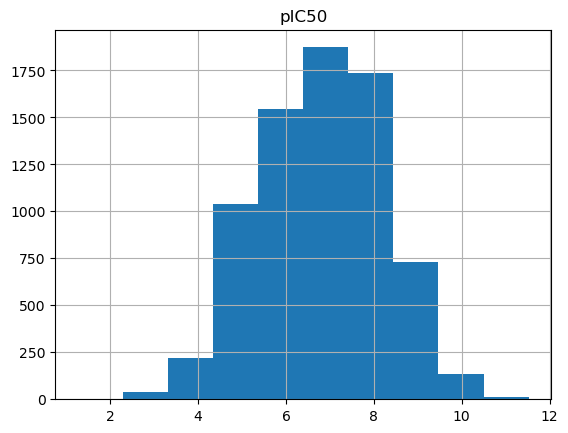

In [70]:
# Plot the distribution of pIC50 values using a histogram.
output_df.hist(column="pIC50")

In [72]:
# Sort the DataFrame by pIC50 in descending order and reset the index.
output_df.sort_values(by="pIC50", ascending=False, inplace=True)
output_df.reset_index(drop=True, inplace=True)

In [73]:
# Display the first 3 rows of the DataFrame after dropping the 'smiles' column.
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL63786,0.003,nM,11.522879,<rdkit.Chem.rdchem.Mol object at 0x00000239322...
1,CHEMBL35820,0.006,nM,11.221849,<rdkit.Chem.rdchem.Mol object at 0x00000239322...
2,CHEMBL53711,0.006,nM,11.221849,<rdkit.Chem.rdchem.Mol object at 0x00000239322...


In [74]:
# Remove the RDKit molecule object column ('ROMol') from the DataFrame
output_df = output_df.drop("ROMol", axis=1)

In [75]:
output_df.shape

(7327, 5)

In [76]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL5270693,0.008,nM,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(C(=O)Oc2cccc...,11.096910


##### **10. Freeze Data to ChEMBL 27**

* **Ensure Reproducibility:** Preserve dataset consistency by freezing data to ChEMBL version 27.

In [79]:
# Define the data directory
DATA = Path("F:/CHEMOINFORMATICS/data")

In [81]:
# Create the directory if it doesn't exist
DATA.mkdir(parents=True, exist_ok=True)

In [82]:
# Save the DataFrame to CSV
output_df.to_csv(DATA / "EGFR_compounds_140325.csv", index=False)

print("File saved successfully!")

File saved successfully!


In [89]:
os.listdir()

['aspirin.mol',
 'aspirin.sdf',
 'benzene.sdf',
 'bio2.yml',
 'data',
 'duplicate counts.csv',
 'EGF2.ipynb',
 'erk2.csv',
 'erk2_column_names.csv',
 'Imatinib.png',
 'imatinib.smi',
 'mayachemtools',
 'PaDEL-Descriptor',
 'PaDEL-Descriptor.zip',
 'sample.csv',
 'vaccine_data.csv']

In [92]:
# Disable this cell to unfreeze the dataset
output_df = pd.read_csv(
    DATA / "EGFR_compounds_140325.csv", index_col=0, float_precision="round_trip"
)

In [93]:
output_df.head()

,IC50,units,smiles,pIC50
molecule_chembl_id,,,,
CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
CHEMBL5270693,0.008,nM,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(C(=O)Oc2cccc...,11.096910


In [94]:
output_df.shape

(7327, 4)